<a href="https://colab.research.google.com/github/FishyDanny/Road-Safety-Risk-Prediction/blob/main/00_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Import data
url = "https://aueprod01ckanstg.blob.core.windows.net/public-catalogue/1633969d-46d3-437f-82e5-4d468db04a9f/bitre_fatalities_may2025.xlsx"
data = pd.read_excel(url, header=4)
print(data.shape)

(57430, 20)


In [ ]:
# Find number of missing data
unknown_indicators = ["Unknown", "unknown", "-9"]
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].replace(unknown_indicators, np.nan)

print("Missing values:")
print(data.isna().sum()[data.isna().sum() > 0].sort_values(ascending=False))

Missing values:
National Road Type                45939
National LGA Name 2021            45829
National Remoteness Areas 2021    45545
SA4 Name 2021                     45545
Heavy Rigid Truck Involvement     20508
Road User                           140
Bus Involvement                      88
Gender                               34
Articulated Truck Involvement        16
Crash Type                           13
dtype: int64


In [ ]:
# Check for pattern of data missingness
missing_road_type = data[data['National Road Type'].isna()]
print("States with missing road types:")
print(missing_road_type['State'].value_counts())

print("\nYears with missing road types:")
print(missing_road_type['Year'].value_counts().sort_index())

States with missing road types:
State
NSW    14020
VIC    10267
QLD     9332
WA      5381
SA      3799
NT      1416
TAS     1293
ACT      431
Name: count, dtype: int64

Years with missing road types:
Year
1989    2800
1990    2331
1991    2113
1992    1974
1993    1953
1994    1928
1995    2017
1996    1970
1997    1767
1998    1755
1999    1764
2000    1817
2001    1737
2002    1715
2003    1621
2004    1583
2005    1627
2006    1598
2007    1603
2008    1437
2009    1491
2010    1353
2011    1277
2012    1300
2013    1186
2014     849
2015     276
2016     563
2017      28
2018      23
2019      23
2020      22
2021      28
2022      17
2023      13
2024     209
2025     171
Name: count, dtype: int64


In [ ]:
# I hypothesis that some features would be less important
# The more important features should be road user, crash type and speed limit
# Thus, we should drop rows missing these critical features
data = data.dropna(subset=['Road User', 'Crash Type', 'Speed Limit'])

# I assume that if heavy rigid truck involvement is missing then it is 0
data['Heavy Rigid Truck Involvement'] = data['Heavy Rigid Truck Involvement'].fillna('No')

/tmp/ipython-input-7-1949808677.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Heavy Rigid Truck Involvement'] = data['Heavy Rigid Truck Involvement'].fillna('No')


In [ ]:
# Verify that rows missing critical features are dropped
print(data.isna().sum()[data.isna().sum() > 0])
print(f"Final shape: {data.shape}")

Bus Involvement                      84
Articulated Truck Involvement        16
Gender                               33
National Remoteness Areas 2021    45472
SA4 Name 2021                     45472
National LGA Name 2021            45756
National Road Type                45863
dtype: int64
Final shape: (57277, 20)


In [ ]:
data['Crash Type'].value_counts()

,count
Crash Type,
Single,31689
Multiple,25588


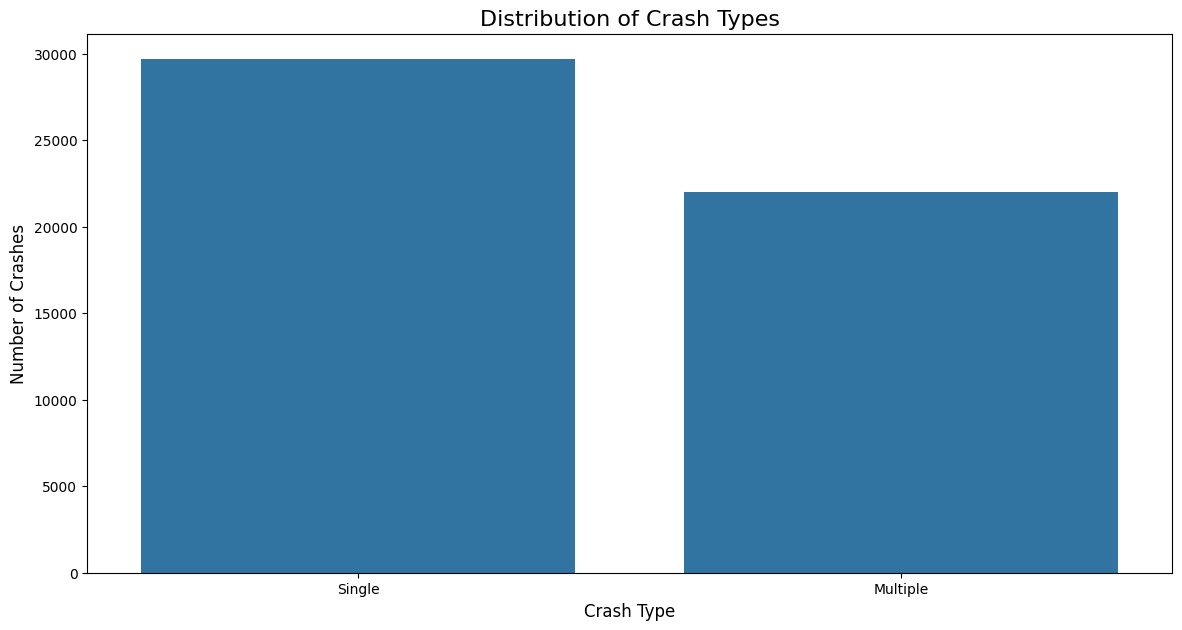

In [ ]:
# Plot 1: Distribution of crashes
crash_data = data.groupby('Crash ID').first().reset_index()

# Plot crash type distribution
plt.figure(figsize=(14, 7))
sns.countplot(
    x='Crash Type',
    data=crash_data,
    order=['Single', 'Multiple']
)
plt.title('Distribution of Crash Types', fontsize=16)
plt.xlabel('Crash Type', fontsize=12)
plt.ylabel('Number of Crashes', fontsize=12)
plt.show()


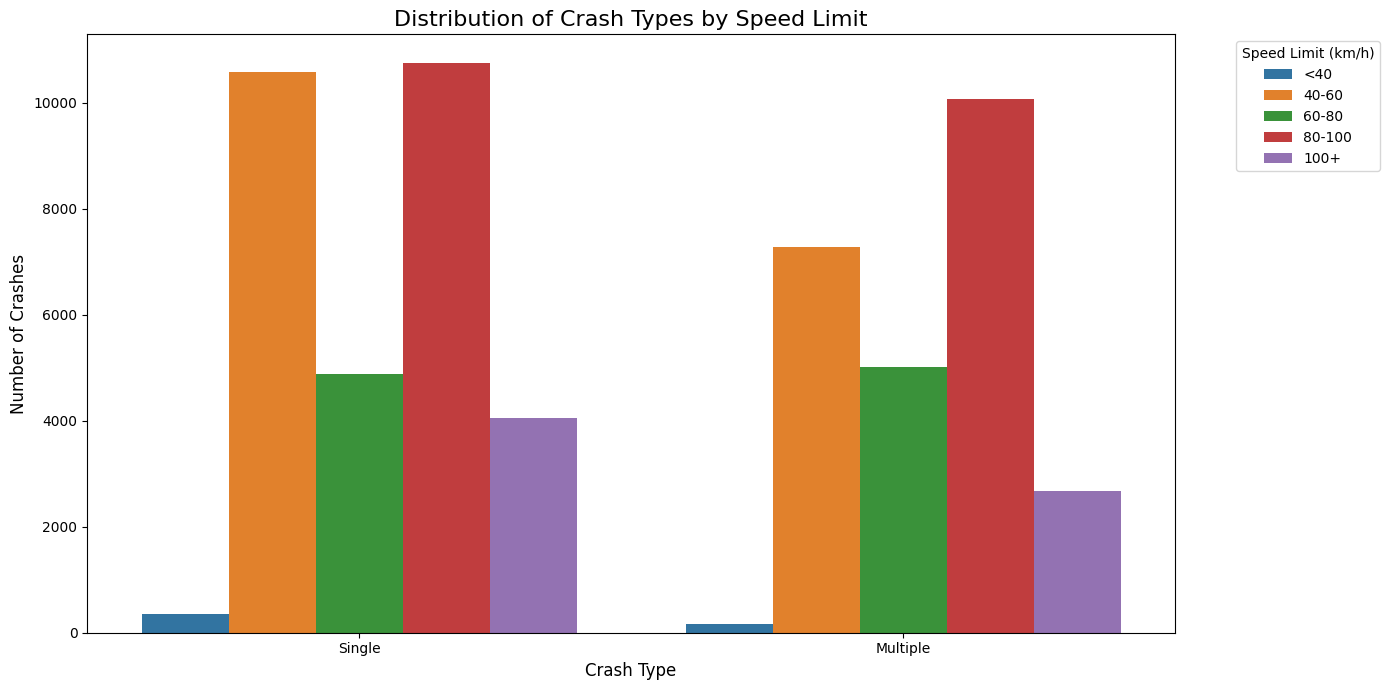

In [ ]:
# Plot: Crash type vs Speed Limit
# Preprocess speed limits (bin if needed)
speed_bins = [0, 40, 60, 80, 100, 130]
speed_labels = ['<40', '40-60', '60-80', '80-100', '100+']
data['Speed_Bin'] = pd.cut(data['Speed Limit'], bins=speed_bins, labels=speed_labels)

# Create plot
plt.figure(figsize=(14, 7))
sns.countplot(
    x='Crash Type',
    hue='Speed_Bin',
    data=data,
    order=['Single', 'Multiple']
)
plt.title('Distribution of Crash Types by Speed Limit', fontsize=16)
plt.xlabel('Crash Type', fontsize=12)
plt.ylabel('Number of Crashes', fontsize=12)
plt.legend(title='Speed Limit (km/h)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

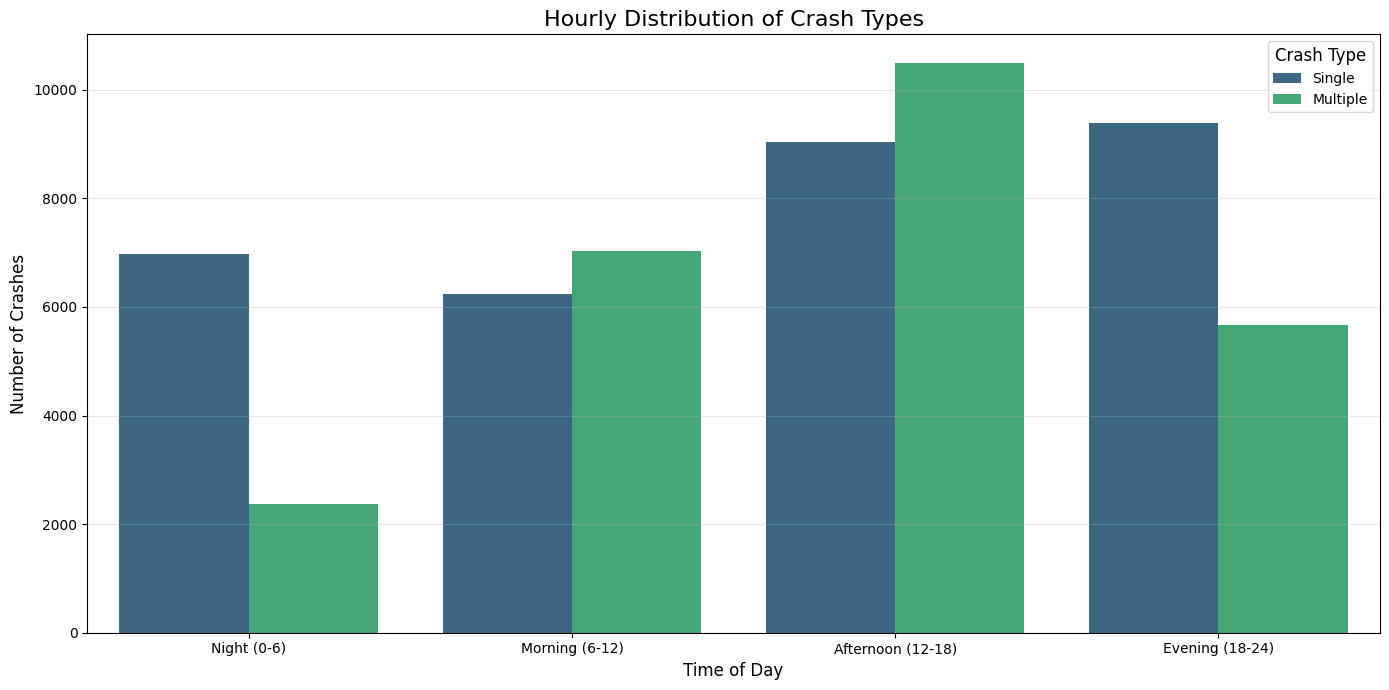

In [ ]:
# Plot: Distribution of crash type by time
# Feature engineer time bins
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S', errors='coerce').dt.hour
time_bins = [0, 6, 12, 18, 24]
time_labels = ['Night (0-6)', 'Morning (6-12)', 'Afternoon (12-18)', 'Evening (18-24)']
data['Time_Category'] = pd.cut(data['Time'], bins=time_bins, labels=time_labels, right=False)

# Plot
plt.figure(figsize=(14, 7))
sns.countplot(
    x='Time_Category',
    hue='Crash Type',
    data=data,
    palette='viridis',
    order=time_labels
)
plt.title('Hourly Distribution of Crash Types', fontsize=16)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Number of Crashes', fontsize=12)
plt.legend(title='Crash Type', title_fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipython-input-13-177356206.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


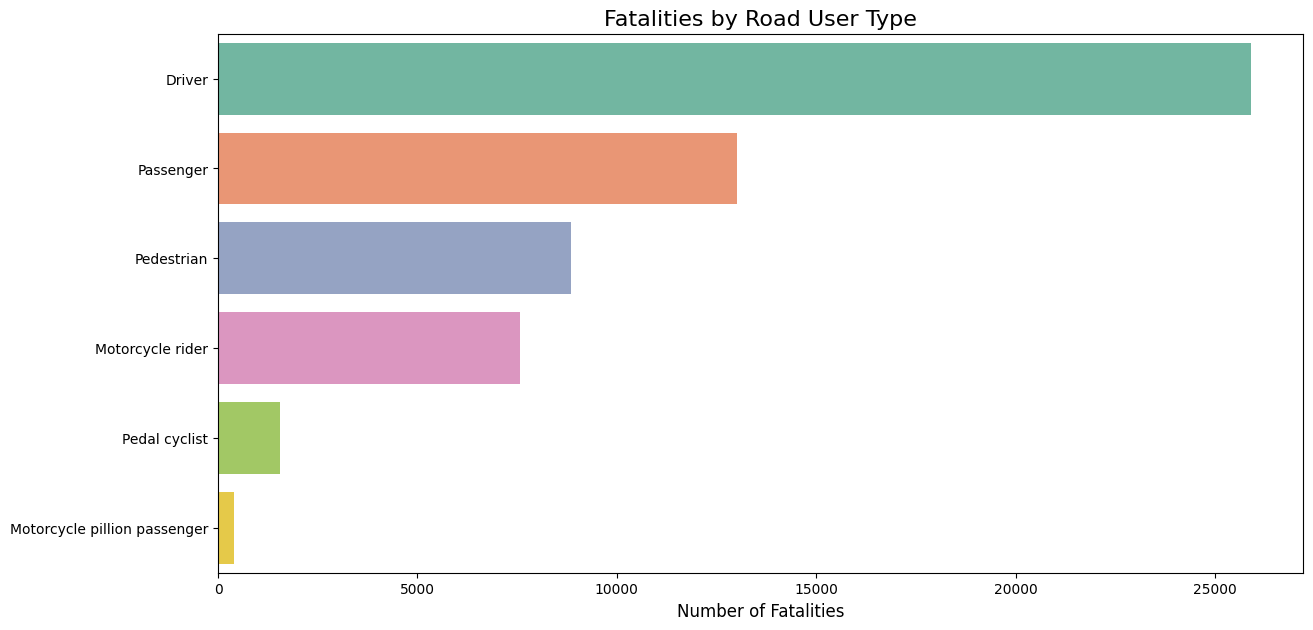

In [ ]:
# Fatalities by Road User Type
plt.figure(figsize=(14, 7))
sns.countplot(
    y='Road User',
    data=data,
    palette='Set2',
    order=data['Road User'].value_counts().index
)
plt.title('Fatalities by Road User Type', fontsize=16)
plt.xlabel('Number of Fatalities', fontsize=12)
plt.ylabel('')
plt.show()

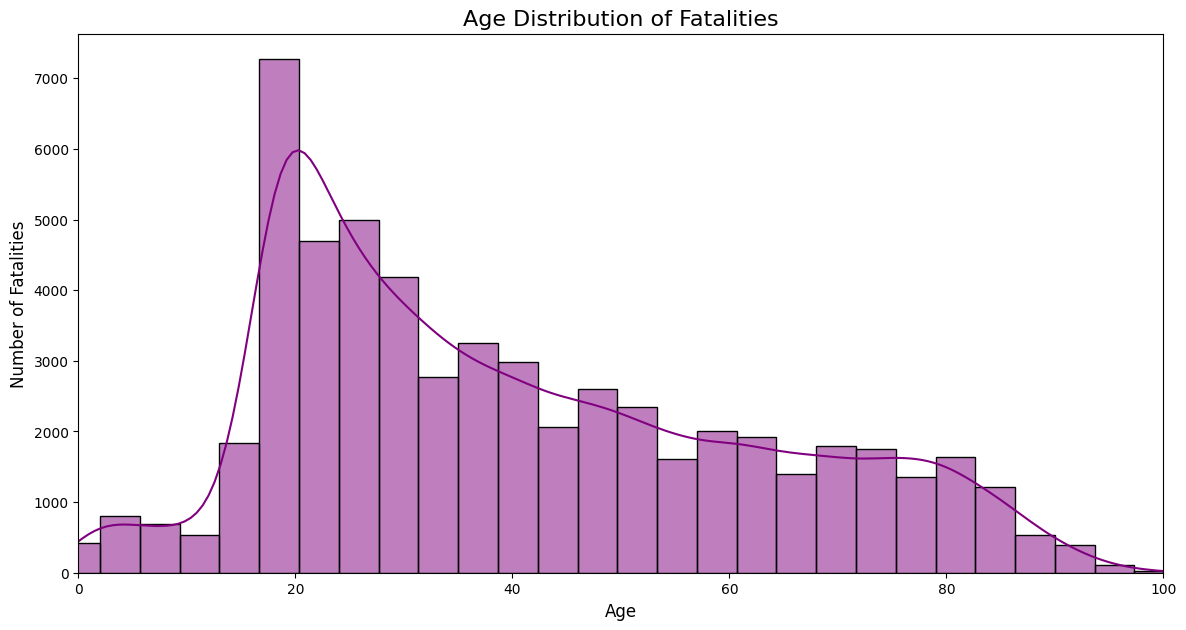

In [ ]:
# Age distribution of victims
plt.figure(figsize=(14, 7))
sns.histplot(
    data['Age'].dropna(),
    bins=30,
    kde=True,
    color='purple'
)
plt.title('Age Distribution of Fatalities', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Number of Fatalities', fontsize=12)
plt.xlim(0, 100)
plt.show()


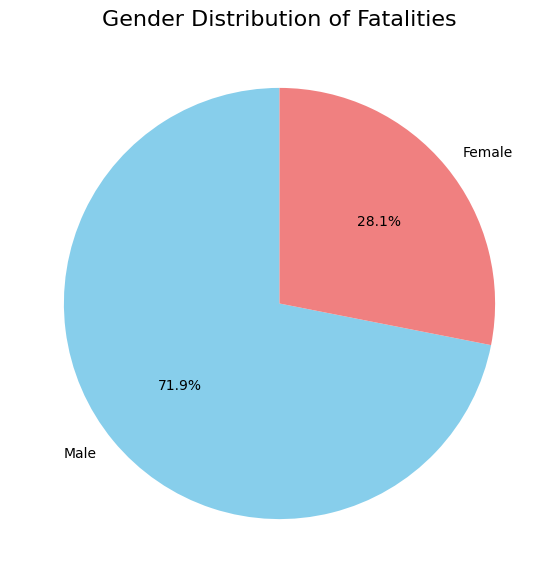

In [ ]:
# Gender distribution
plt.figure(figsize=(14, 7))
data['Gender'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=['skyblue', 'lightcoral', 'lightgrey'],
    startangle=90
)
plt.title('Gender Distribution of Fatalities', fontsize=16)
plt.ylabel('')
plt.show()